In [1]:
import numpy; print("numpy:", numpy.__version__)
import tensorflow; print("tf:", tensorflow.__version__)
import keras; print("keras:", keras.__version__)

numpy: 1.26.4


2026-02-26 14:10:16.154188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf: 2.16.2
keras: 3.3.3


In [3]:
pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 3.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 9.8 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [huggingface_hub] [huggingface_hub]
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import boto3
import numpy as np
import pandas as pd
import tempfile
import keras
from huggingface_hub import hf_hub_download
from tornet.data.loader import read_file
import xarray as xr

print("numpy:", np.__version__)

# Setup S3
s3_client = boto3.client('s3')
bucket_name = 'ml-cloud-project-data'

# Download CSV from S3
s3_client.download_file(bucket_name, 'choo_choo_data_1.csv', 'choo_choo_data_1.csv')
df = pd.read_csv('choo_choo_data_1.csv')
print(f"Loaded {len(df)} rows")
print(df.head(2))

# Load pretrained model
model_file = hf_hub_download(
    repo_id="tornet-ml/tornado_detector_baseline_v1",
    filename="tornado_detector_baseline.keras"
)
cnn = keras.models.load_model(model_file, compile=False)
print("Model inputs:", list(cnn.input.keys()))

# Run inference
variables = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']
results = []

def make_coordinates(filepath, frame_idx):
    """Build the coordinates input the model expects from az/range dims"""
    ds = xr.open_dataset(filepath)
    az = ds['azimuth'].values        # (120,)
    rng = ds['range'].values         # (240,)
    
    # Create meshgrid and stack into coordinate array
    az_grid, rng_grid = np.meshgrid(az, rng, indexing='ij')  # (120, 240)
    
    # Normalize to roughly [-1, 1] range
    az_norm = az_grid / 360.0
    rng_norm = rng_grid / 150000.0  # max range ~150km
    
    # Stack into (1, 120, 240, 2)
    coords = np.stack([az_norm, rng_norm], axis=-1)[np.newaxis].astype(np.float32)
    ds.close()
    return coords

for k, v in cnn.input.items():
    print(k, v.shape)

for _, row in df.iterrows():
    s3_key = row['filepath'].replace(f's3://{bucket_name}/', '')
    frame_idx = row['frame_idx']
    
    try:
        with tempfile.NamedTemporaryFile(suffix='.nc', delete=True) as tmp:
            s3_client.download_file(bucket_name, s3_key, tmp.name)
            data = read_file(tmp.name, variables=variables, n_frames=4)
            coords = make_coordinates(tmp.name, frame_idx)
        
        xin = {k: data[k][[frame_idx]] for k in cnn.input if k in data}
        xin['coordinates'] = coords  # add coordinates
        
        logit = cnn.predict(xin, verbose=0)
        prob = float(1 / (1 + np.exp(-logit[0, 0])))
        
        results.append({
            'filepath': row['filepath'],
            'event_id': row['event_id'],
            'frame_idx': frame_idx,
            'label': row['label'],
            'tornado_prob': prob
        })
        print(f"✓ {row['event_id']} frame {frame_idx} → prob={prob:.3f}")

    except Exception as e:
        print(f"✗ Failed {row['event_id']} frame {frame_idx}: {e}")
        continue

results_df = pd.DataFrame(results)
results_df.to_csv('pretrained_inference_results.csv', index=False)

# Upload results back to S3
s3_client.upload_file('pretrained_inference_results.csv', bucket_name, 'pretrained_inference_results.csv')
print(f"\nDone. {len(results_df)}/{len(df)} succeeded.")

numpy: 1.26.4
Loaded 231 rows
                                            filepath  \
0  s3://ml-cloud-project-data/tornet_2014/train/2...   
1  s3://ml-cloud-project-data/tornet_2014/train/2...   

                           event_id  frame_idx         label  
0  TOR_140404_020014_KPAH_504204_P0          0  tornado_hook  
1  TOR_140404_020014_KPAH_504204_P0          1  tornado_hook  
Model inputs: ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH', 'range_folded_mask', 'coordinates']
DBZ (None, None, None, 2)
VEL (None, None, None, 2)
KDP (None, None, None, 2)
RHOHV (None, None, None, 2)
ZDR (None, None, None, 2)
WIDTH (None, None, None, 2)
range_folded_mask (None, None, None, 2)
coordinates (None, None, None, 2)
✓ TOR_140404_020014_KPAH_504204_P0 frame 0 → prob=0.006
✓ TOR_140404_020014_KPAH_504204_P0 frame 1 → prob=0.003
✓ TOR_140404_020014_KPAH_504204_P0 frame 2 → prob=0.035
✓ TOR_160523_003937_KMAF_631193_Y0 frame 0 → prob=0.197
✓ TOR_160523_003937_KMAF_631193_Y0 frame 1 → prob=0.235
✓

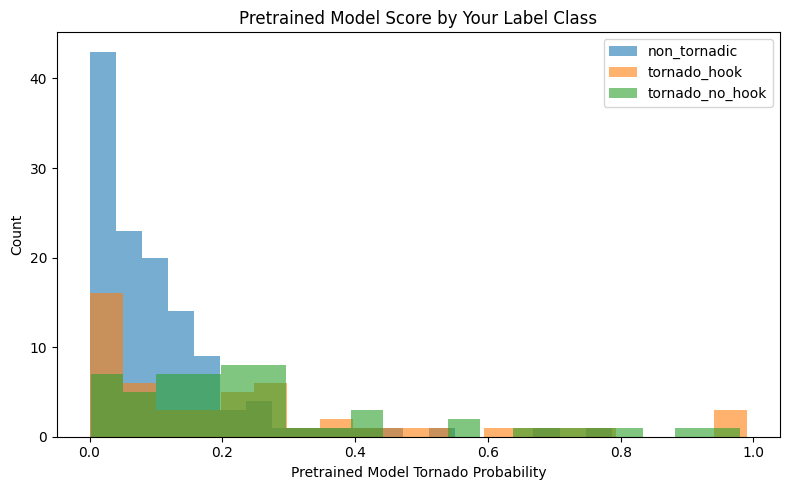

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
for label, group in results_df.groupby('label'):
    ax.hist(group['tornado_prob'], bins=20, alpha=0.6, label=label)
ax.set_xlabel('Pretrained Model Tornado Probability')
ax.set_ylabel('Count')
ax.legend()
plt.title('Pretrained Model Score by Your Label Class')
plt.tight_layout()
plt.savefig('score_distribution.png')
plt.show()

In [6]:
import tensorflow as tf
from tornet.data.loader import read_file
from sklearn.model_selection import train_test_split

LABEL_MAP = {'non_tornadic': 0, 'tornado_no_hook': 1, 'tornado_hook': 2}
variables = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

df = pd.read_csv('choo_choo_data_1.csv')
df['label_int'] = df['label'].map(LABEL_MAP)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_int'], random_state=42)

def make_dataset(split_df, batch_size=8):
    def generator():
        for _, row in split_df.iterrows():
            filepath = row['filepath'].replace('s3://ml-cloud-project-data/', '/your/local/mount/')
            data = read_file(filepath, variables=variables, n_frames=4)
            frame_idx = row['frame_idx']
            x = {k: data[k][[frame_idx]] for k in variables if k in data}
            y = row['label_int']
            yield x, y

    # Infer output signature from one sample
    sample_x, sample_y = next(generator())
    output_sig = (
        {k: tf.TensorSpec(shape=v.shape, dtype=tf.float32) for k, v in sample_x.items()},
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    ds = tf.data.Dataset.from_generator(generator, output_signature=output_sig)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

# Build fine-tune model: strip the binary head, add 3-class head
base_model = keras.models.load_model(model_file, compile=False)

# Freeze base layers initially
for layer in base_model.layers[:-3]:  # unfreeze last few layers
    layer.trainable = False

# Replace output head
x = base_model.layers[-2].output  # second-to-last layer output
out = keras.layers.Dense(3, activation='softmax', name='class_output')(x)
fine_tune_model = keras.Model(inputs=base_model.input, outputs=out)

fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = fine_tune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('hook_detector_finetuned.keras', save_best_only=True)
    ]
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/your/local/mount/tornet_2021/train/2021/WRN_211231_225220_KFFC_1086857n_D8.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)